<a href="https://colab.research.google.com/github/Raspberry765/maching_learning/blob/main/Local_Outlier_Factor_load_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install umap-learn[plot]
! pip install umap-learn

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
import umap.plot
#! pip uninstall umap
#Because I use this in colab, there some colab commands... sorry about that.
#!pip install -q tensorflow-gpu==2.0.0-rc1
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import confusion_matrix
from keras.models import Model
import umap
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Model
#from tensorflow.python.keras.models import load_model
from tensorflow import keras
#from tensorflow.keras.layers import load_model
from tensorflow.keras.models import Sequential, load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 4.0 MB/s 
     |████████████████████████████████| 1.1 MB 63.1 MB/s 
     |████████████████████████████████| 18.2 MB 1.9 MB/s 
     |████████████████████████████████| 76 kB 2.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=c37a13d24e3e3aa61442a71bb896877e8659d46035abd1b5ac21633584d6e4ab
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=938a4ad92eb7407ae80e7da4186c8691460c0501140f00040e35995886ca2857
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
  Created wheel for datashape: filename=datashape-0.5.2-py3-none-any.whl size=59439 sha256=aed2fddee5e9cd35282181c6035fc2755bcca8c223eb6b45cb

# L2レイヤーの定義

In [2]:
# Metric lerning（L2ノルム正則化）
"""
#If you don't need to learn alpha , you can choose below way too.
alpha = 30
def l2_constrain(x):
    return alpha * K.l2_normalize(x, axis=1)
model.add(layers.Lambda(l2_constrain))
"""

#This is custom layer way
# If you use trainable variables, you should write this way
# ref : https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda#variables
class L2ConstrainLayer(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(L2ConstrainLayer, self).__init__()
        self.alpha = tf.Variable(30.)

    def call(self, inputs):
        #about l2_normalize https://www.tensorflow.org/api_docs/python/tf/keras/backend/l2_normalize?hl=ja
        #print("call予備")
        return K.l2_normalize(inputs, axis=1) * self.alpha
    # def get_config(self):
    #     config = {'self': self.alpha}
    #     base_config = super(L2ConstrainLayer, self).get_config()
    #     return dict(list(base_config.items()) + list(config.items()))
    #     #return dict(list(base_config.items()) )

#機械学習モデルロード

In [3]:
load_model = load_model("/content/drive/MyDrive/aicop/model_weightv3-0003.h5",custom_objects={'L2ConstrainLayer':L2ConstrainLayer})
load_model.summary() #モデル情報を出力


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 576)              

# データセット用意

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

train_images, test_images = [train_images / 255.0, test_images / 255.0]

11490434/11490434 [==============================] - 0s 0us/step


# 中間層の出力

In [6]:
#model = ...  # create the original model
layer_name = 'l2_constrain_layer' #エラーになった場合は上のmodelの層からsoftmaxの前の層の名前をとる。（l2_constrain_layer_？）になってたりする
intermediate_layer_model = Model(inputs=load_model.input,
                                 outputs=load_model.get_layer(layer_name).output)

# 学習の関数の定義

In [7]:
# 1回ずつエポックを実施する関数を定義
def train_2(model, X_train, y_train, epoch, batch):

    acc = []
    val_acc = []
    loss = []
    val_loss = []

    for i in range(0,epoch, 1):
        # # パラメータ更新前の分布
        print(str(i),"実行中")
        print("エポック回数",str(epoch))
        hidden = intermediate_layer_model.predict(X_train)
        print("UMAP実行中")
        #hid_co = umap.UMAP(n_components=2, n_neighbors=40, verbose=1).fit(hidden)
        hid_co = umap.UMAP().fit(hidden)
        embedding_x = hid_co.embedding_[:, 0]
        embedding_y = hid_co.embedding_[:, 1]
        print("UMAP終了")
        plt.figure(figsize=(8,6))
        plt.xlim(-20,20) #x軸範囲指定
        plt.ylim(-20,20) #y軸範囲指定
        for nn in np.unique(y_train):
          plt.scatter(embedding_x[y_train == nn],
                    embedding_y[y_train == nn],
                    label=nn)
        #plt.colorbar()
        plt.legend()
        plt.title('Epoch  ' + str(i))
        plt.show()
        #plt.savefig('./fig/epoch_' + '{0:03d}'.format(i) + '.png', bbox_inches='tight')
        plt.close()
#        mapper = umap.UMAP().fit(hidden)
#        umap.plot.points(mapper, labels=y_train)
        # # 1epochだけ学習
        #history = model.fit(X_train, y_train, epochs=1, batch_size=batch, validation_split=0.2, verbose=1)
        
        # 重みをチェックポイントファイルへ出力
        #checkpoint_path = "result_CNN/checkpoint-{epoch:04d}.ckpt"
        #checkpoint_dir = os.path.dirname(checkpoint_path)

        # 1エポックごとにモデルの重みを保存するコールバックを作成
        #cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,verbose=1,save_weights_only=True,
        #period=1)

        # `checkpoint_path` フォーマットで重みを保存
        #model.save_weights(checkpoint_path.format(epoch=0))

        # checkpoint_path = "result_CNN/model_weight-{epoch:04d}.h5"
        # model.save(checkpoint_path.format(epoch=i))
        
        
        # # # 1epochだけ学習
        # history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch),
        #                       steps_per_epoch=len(X_train) / batch,
        #                       epochs=1,validation_data=(x_test, y_test),verbose=1)
        

        # # Lossなど保存
        # acc.append(history.history['accuracy'])
        # val_acc.append(history.history['val_accuracy'])
        # loss.append(history.history['loss'])
        # val_loss.append(history.history['val_loss'])
    return embedding_x,embedding_y

# 学習の実行

In [8]:
batch = 8
epoch = 2
x_data,y_data=train_2(load_model,train_images, train_labels, epoch=2, batch=100)

0 実行中
エポック回数 2
 572/1875 [========>.....................] - ETA: 9s

KeyboardInterrupt: ignored

# 深層距離学習結果ロード

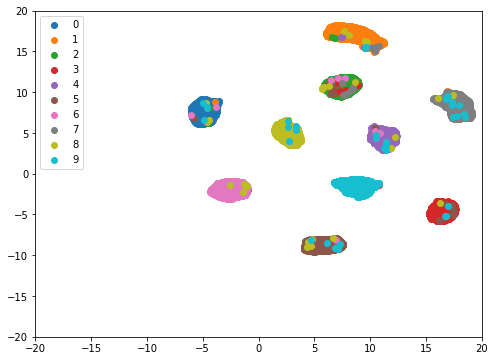

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(8,6))
for nn in np.unique(train_labels):
  plt.xlim(-20,20) #x軸範囲指定
  plt.ylim(-20,20) #y軸範囲指定
  plt.scatter(x_data[train_labels == nn],y_data[train_labels == nn],label=nn)
#  plt.colorbar()
  plt.legend()
plt.show()
plt.close()


In [ ]:
data_0 = np.stack([x_data[train_labels == 0],y_data[train_labels == 0]])
data_1 = np.stack([x_data[train_labels == 1],y_data[train_labels == 1]])
data_2 = np.stack([x_data[train_labels == 2],y_data[train_labels == 2]])
data_3 = np.stack([x_data[train_labels == 3],y_data[train_labels == 3]])
data_4 = np.stack([x_data[train_labels == 4],y_data[train_labels == 4]])
data_5 = np.stack([x_data[train_labels == 5],y_data[train_labels == 5]])
data_6 = np.stack([x_data[train_labels == 6],y_data[train_labels == 6]])
data_7 = np.stack([x_data[train_labels == 7],y_data[train_labels == 7]])
data_8 = np.stack([x_data[train_labels == 8],y_data[train_labels == 8]])
data_9 = np.stack([x_data[train_labels == 9],y_data[train_labels == 9]])
data_hor_2_7 = np.concatenate([data_0,data_1,data_2,data_3,data_4,data_5,data_6,data_7,data_8,data_9],1)
data_hor_2_7_T = data_hor_2_7.T
print("data.shape:",data_2.shape)
print("data.shape:",data_7.shape)
#print(data[y_train==1])
print(data_hor_2_7.shape)

data.shape: (2, 5958)
data.shape: (2, 6265)
(2, 60000)


## LOF



In [ ]:
clf = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.001)
clf.fit(data_hor_2_7_T)

NameError: ignored

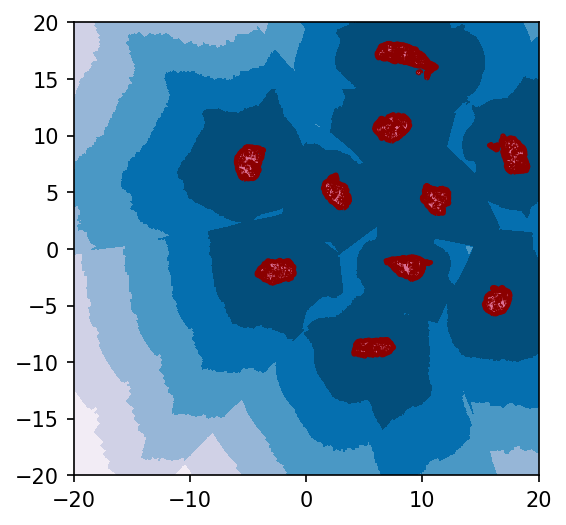

In [ ]:
xx, yy = np.meshgrid(np.linspace(-20, 20, 2000), np.linspace(-20, 20, 2000))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(4, 4), dpi=150)

##座標作成
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
# b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
# b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s,
#                  edgecolors='k')
# c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s,
#                 edgecolors='k')
# plt.title('Detection with LOF')
# plt.axis('tight')
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
# plt.legend([a.collections[0], b1, b2, c],
#            ['learned frontier', 'training data',
#             'test data (normal)', 'test data (abnormal'],
#            loc="upper left",
#            prop=matplotlib.font_manager.FontProperties(size=11))
plt.show()

# テストデータ作成


#test_data = intermediate_layer_model.predict(train_images)
#hid_co = umap.UMAP(n_components=2, n_neighbors=40, verbose=1).fit(test_data)
#embedding_x = hid_co.embedding_[:, 0]
#embedding_y = hid_co.embedding_[:, 1]
x_data,y_data=train_2(load_model,test_images, test_labels, epoch=1, batch=100)

313/313 [==============================] - 4s 13ms/step


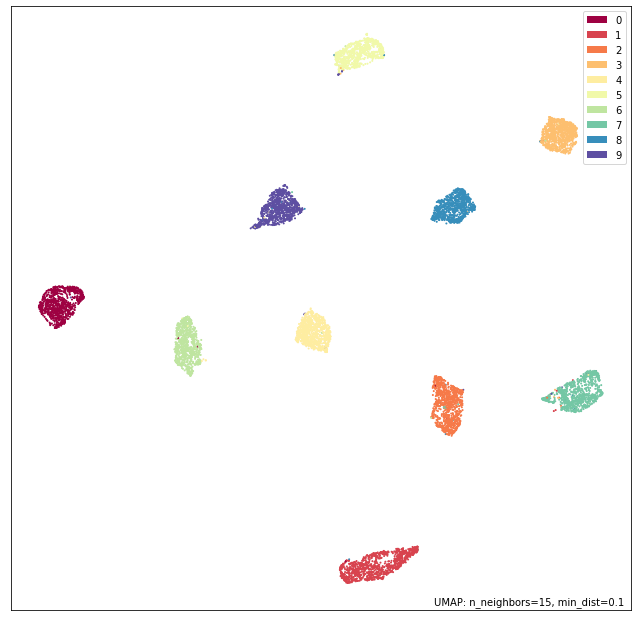

In [ ]:
hidden = intermediate_layer_model.predict(test_images)
mapper = umap.UMAP().fit(hidden)
umap.plot.points(mapper, labels=test_labels)
#x_data,y_data=train_2(load_model,test_images, test_labels, epoch=1, batch=100)

1875/1875 [==============================] - 14s 8ms/step


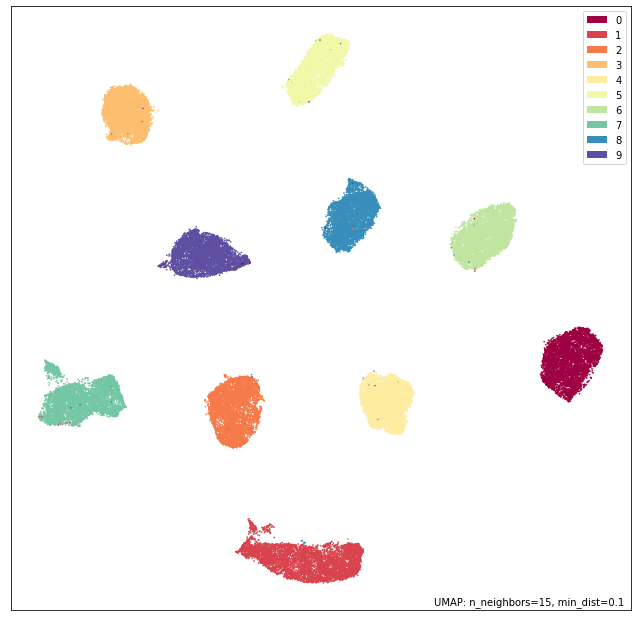

In [ ]:
hidden_train = intermediate_layer_model.predict(train_images)
mapper_train = umap.UMAP().fit(hidden_train)
umap.plot.points(mapper_train, labels=train_labels)


# print("UMAP実行中")
# #hid_co = umap.UMAP(n_components=2, n_neighbors=40, verbose=1).fit(hidden)
# hid_co = umap.UMAP().fit(hidden)
# embedding_x = hid_co.embedding_[:, 0]
# embedding_y = hid_co.embedding_[:, 1]
# print("UMAP終了")
# plt.figure(figsize=(8,6))
# plt.xlim(-20,20) #x軸範囲指定
# plt.ylim(-20,20) #y軸範囲指定
# for nn in np.unique(test_labels):
#   plt.scatter(embedding_x[test_labels == nn],
#             embedding_y[test_labels == nn],
#             label=nn)
# #plt.colorbar()
# plt.legend()
# plt.title('Epoch  ' + str(i))
# plt.show()

313/313 [==============================] - 3s 9ms/step


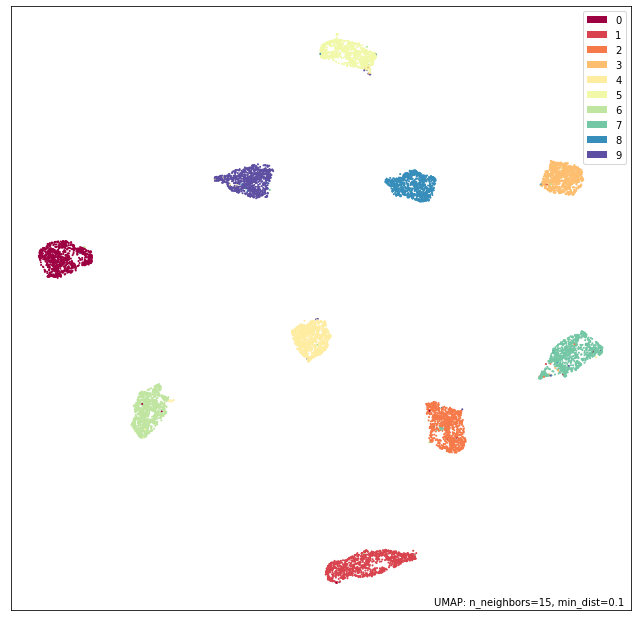

In [ ]:
hidden_test = intermediate_layer_model.predict(test_images)
mapper_test = umap.UMAP().fit(hidden_test)
umap.plot.points(mapper_test, labels=test_labels)


#clf定義

In [ ]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.01,novelty=True)

# 服データ

313/313 [==============================] - 3s 10ms/step


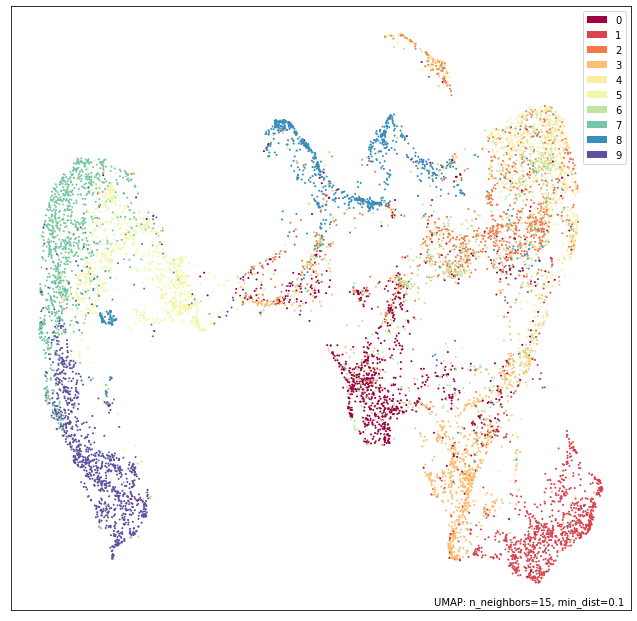

In [ ]:
from keras.datasets import fashion_mnist

(x_train_fashion, y_train_fashion), (x_test_fashion, y_test_fashion) = fashion_mnist.load_data()
train_images_fashion = x_train_fashion.reshape((60000, 28, 28, 1))
test_images_fashion = x_test_fashion.reshape((10000, 28, 28, 1))

train_images_fashion, test_images_fashion = [train_images_fashion / 255.0, test_images_fashion / 255.0]

hidden_test_fashion = intermediate_layer_model.predict(test_images_fashion)

#hidden_train = intermediate_layer_model.predict(train_images)
#mapper_train = umap.UMAP().fit(hidden_train)
#umap.plot.points(mapper_train, labels=train_labels)
mapper_fashion = umap.UMAP().fit(hidden_test_fashion)
umap.plot.points(mapper_fashion, labels=y_test_fashion)

## 異常検知実装


1.   [参考サイト　Novelty detection with Local Outlier Factor](https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_novelty_detection.html#sphx-glr-auto-examples-neighbors-plot-lof-novelty-detection-py)

2.   [sclearnのLOF公式](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor.predict)




In [ ]:
#https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_novelty_detection.html#sphx-glr-auto-examples-neighbors-plot-lof-novelty-detection-py

clf.fit(mapper_train.embedding_)
y_pred_test_mnist_moji = clf.predict(mapper_test.embedding_)
n_error_test_mnist_moji = y_pred_test_mnist_moji[y_pred_test_mnist_moji == -1].size
y_pred_outliers = clf.predict(mapper_fashion.embedding_) #Returns -1 for anomalies/outliers and +1 for inliers.
n_error_outliers  = y_pred_outliers[y_pred_outliers == 1].size
print("服の異常値の数",n_error_outliers )#検出の数が逆なような気がする
print("文字の異常値の数",n_error_test_mnist_moji )#検出の数が逆なような気がする

服の異常値の数 2298
文字の異常値の数 9930


In [ ]:
index_num = np.array((range(0,10000,1)))
#len(index_num)

index_result = index_num[y_pred_outliers == 1] 
#index_result
index_result[0]

41

LocalOutlierFactor(contamination=0.01, novelty=True)

In [ ]:
ANOMALY_DATA = -1
predicted_outlier_index = np.where(outlier_scores == ANOMALY_DATA)
index_data=predicted_outlier_index[0]
print(index_data)
#redicted_outlier = X[predicted_outlier_index]


[ 797 1549 2182 3060 3906 4152 4201 6598 6740 9814 9830 9831 9841 9853
 9877]


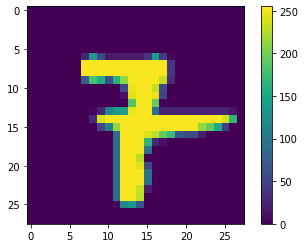

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
import matplotlib.pyplot as plt
index=22
plt.imshow(test_images[index_result[1]])
plt.colorbar()

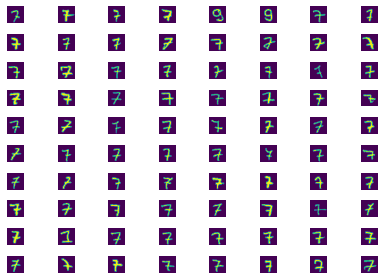

In [ ]:
nrows=10
ncols=8
 
# squeeze=Falseとしておけば、ncols=1でもaxes[i,j]と書ける
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False, tight_layout=True)
ii=0
for i in range(nrows):
  for j in range(ncols):
    axes[i,j].imshow(test_images[ index_result[ii] ])
    axes[i,j].axis("off")
    #axes[i,j].set_title(f"plot({i}, {j})")
    ii = ii +1
 
plt.show()

In [ ]:
hidden_fashion = intermediate_layer_model.predict(train_images_fashion)
mapper_fashion = umap.UMAP().fit(hidden_fashion)


1875/1875 [==============================] - 23s 12ms/step


In [ ]:
outlier_scores = sklearn.neighbors.LocalOutlierFactor(contamination=0.001428).fit_predict(mapper_fashion.embedding_)
y_pred_fashion = clf.fit_predict(mapper.embedding_,mapper_fashion.embedding_)

In [ ]:
ANOMALY_DATA = -1
predicted_outlier_index = np.where(outlier_scores == ANOMALY_DATA)
index_data=predicted_outlier_index[0]
print(index_data)

[  887  1260  1742  2920  3056  3800  4051  4467  4752  4802  5484  5556
  6256  6446  6562  7559  8035  8066  8076  9080  9584  9648  9780 11169
 11820 13158 13397 14618 15048 15737 16664 16812 19019 19487 19958 20430
 21310 21381 22826 22899 23461 23671 24459 26423 27409 27604 28674 29516
 29720 34098 34547 34617 36767 40154 42989 43215 43277 44125 44592 45740
 46087 48107 48243 50502 51031 51156 51465 51968 52832 52958 53165 54108
 54941 55181 55184 55275 56399 56492 56575 56834 56886 57476 57504 57513
 58036 58283]


In [ ]:
import sklearn
sklearn.__version__

'1.0.2'